# Age and Education Level of 2017 Czech Parliament Election Candidates

Choose at least three parties that are going to participate in the election.
Scrap the web pages https://volby.cz to get list of all candidates for the chosen parties
(good place to start: https://volby.cz/pls/ps2017/ps11?xjazyk=CZ&xv=1&xt=1).

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
def read_party_df(url):
    r = requests.get(url)
    dfs = pd.read_html(r.text, flavor='bs4', skiprows=2)
    column_names = {1: 'Kraj', 2: 'Number', 3: 'Name', 4: 'Age',
                    5: 'Party', 6: 'Political affiliation'}
    # first two rows are columns names
    # drop uninmportant columns
    # correct columns names
    return dfs[0].drop([0, 1])\
                 .drop([0, 7, 8], axis=1)\
                 .rename(index=lambda x: x - 2, columns=column_names)

In [4]:
urls = {
    'ANO': 'https://volby.cz/pls/ps2017/ps111?xjazyk=CZ&xkraj=0&xstrana=21&xv=1&xt=1',
    'DSSS': 'https://volby.cz/pls/ps2017/ps111?xjazyk=CZ&xkraj=0&xstrana=28&xv=1&xt=1',
    'KSČM': 'https://volby.cz/pls/ps2017/ps111?xjazyk=CZ&xkraj=0&xstrana=8&xv=1&xt=1',
    'Piráti': 'https://volby.cz/pls/ps2017/ps111?xjazyk=CZ&xkraj=0&xstrana=15&xv=1&xt=1',
}

df = pd.concat({party: read_party_df(url) for party, url in urls.items()})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1359 entries, (ANO, 0) to (Piráti, 335)
Data columns (total 6 columns):
Kraj                     1359 non-null object
Number                   1359 non-null int64
Name                     1359 non-null object
Age                      1359 non-null int64
Party                    1359 non-null object
Political affiliation    1359 non-null object
dtypes: int64(2), object(4)
memory usage: 70.4+ KB


In [6]:
df.head()

Kraj  Number                          Name  Age Party  \
ANO 0       Pardubický      14                 Akerman Miloš   61   ANO   
    1          Ústecký      22              Andrš Radek Ing.   48   ANO   
    2      Karlovarský      10  Arnoldová Lenka Mgr. et Mgr.   52   ANO   
    3     Jihomoravský      24     Artimová Zuzana Olga Ing.   53   ANO   
    4  Moravskoslezský      27            Babinec Radim Mgr.   43   ANO   

      Political affiliation  
ANO 0                   ANO  
    1                   ANO  
    2                   ANO  
    3                   ANO  
    4                   ANO

## 1. Use Data Visualisation to Depict the Age Distribution of Candidates
    
- How many candidates are young/old/middle aged?
- Which party has older candidates compared to the others?

In [7]:
df['Age'].groupby(level=0).describe()

,count,mean,std,min,25%,50%,75%,max
ANO,341.0,48.580645,10.252264,22.0,42.0,48.0,56.0,72.0
DSSS,341.0,44.422287,12.944587,21.0,34.0,44.0,53.0,74.0
KSČM,341.0,49.841642,12.639044,21.0,41.0,51.0,61.0,74.0
Piráti,336.0,37.157738,10.743778,21.0,30.0,34.0,43.0,71.0


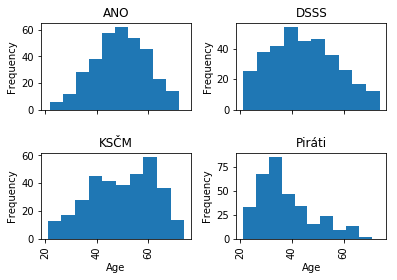

In [8]:
axes = df.hist(column='Age', by='Party', sharex=True)
for ax in axes.ravel():
    ax.set_xlabel('Age')
    ax.set_ylabel('Frequency')

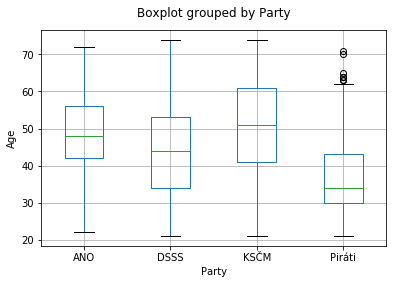

In [9]:
ax = df.boxplot(column='Age', by='Party')
ax.set_title('')
ax.set_ylabel('Age')

## 2. Use the Titles of Candidates to Get the Idea on Education Levels


Try to distinguish at least three education levels corresponding to:

- no title,
- Bc.,
- Ing., Mgr. and analogous and higher.
    
E.g. *Barteček Ivo prof. PhDr. CSc.* has three titles 'prof.', 'PhDr.' and 'CSc.'.

Your visualisation should answer at least these questions:

- How frequent are the education levels of candidates for each of the chousen parties?
- How *'educated'* is each party compared to the others?
- How frequent is each education level within all candidates?